[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomCorridor-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 19:33:34,820] Making new env: ppaquette/DoomCorridor-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 5

0.0 False


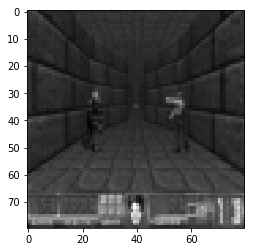

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 19:33:35,727] Making new env: ppaquette/DoomCorridor-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[4 3 3 0 6 0 4]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 85.1 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 19:33:52,351] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:33:52,361] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 19:33:52,604] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.13112.video000000.mp4


Episode finished after 83 timesteps with reward=-115.99455261230469


[2017-06-26 19:33:54,781] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.13112.video000001.mp4


Episode finished after 34 timesteps with reward=28.293701171875
Episode finished after 66 timesteps with reward=-115.99006652832031
Episode finished after 177 timesteps with reward=-55.01985168457031
Episode finished after 87 timesteps with reward=-115.99278259277344
Episode finished after 420 timesteps with reward=223.0233154296875
Episode finished after 28 timesteps with reward=121.4775390625


[2017-06-26 19:34:06,654] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.13112.video000008.mp4


Episode finished after 57 timesteps with reward=-111.69264221191406
Episode finished after 74 timesteps with reward=41.69786071777344


[2017-06-26 19:34:10,933] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 171 timesteps with reward=-23.98785400390625


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 10/2000 [00:01<04:17,  7.72it/s]

iter=10	epsilon=0.954	reward/step=1.16214


  1%|          | 20/2000 [00:02<04:07,  7.99it/s]

iter=20	epsilon=0.910	reward/step=0.41670


  2%|▏         | 30/2000 [00:03<04:05,  8.03it/s]

iter=30	epsilon=0.868	reward/step=0.96334


  2%|▏         | 40/2000 [00:04<04:01,  8.13it/s]

iter=40	epsilon=0.828	reward/step=0.95381


  2%|▏         | 49/2000 [00:05<03:47,  8.58it/s][2017-06-26 19:34:16,946] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:34:16,950] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=1.09321


[2017-06-26 19:34:17,795] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:06<12:25,  2.62it/s]

Episode finished after 46 timesteps with reward=308.2085266113281


  3%|▎         | 60/2000 [00:07<04:22,  7.39it/s]

iter=60	epsilon=0.754	reward/step=1.75444


  4%|▎         | 71/2000 [00:09<03:55,  8.18it/s]

iter=70	epsilon=0.719	reward/step=2.63446


  4%|▍         | 81/2000 [00:10<04:04,  7.86it/s]

iter=80	epsilon=0.687	reward/step=3.55068


  5%|▍         | 91/2000 [00:11<04:06,  7.75it/s]

iter=90	epsilon=0.656	reward/step=3.82067


  5%|▍         | 99/2000 [00:12<04:16,  7.42it/s][2017-06-26 19:34:24,132] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:34:24,140] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=4.60576


[2017-06-26 19:34:25,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 101/2000 [00:14<13:14,  2.39it/s]

Episode finished after 84 timesteps with reward=690.8603363037109


  6%|▌         | 111/2000 [00:15<04:39,  6.77it/s]

iter=110	epsilon=0.598	reward/step=4.58623


  6%|▌         | 121/2000 [00:17<04:26,  7.05it/s]

iter=120	epsilon=0.571	reward/step=4.84539


  7%|▋         | 131/2000 [00:18<04:35,  6.79it/s]

iter=130	epsilon=0.546	reward/step=5.19152


  7%|▋         | 141/2000 [00:20<04:44,  6.53it/s]

iter=140	epsilon=0.522	reward/step=5.61542


  7%|▋         | 149/2000 [00:21<04:55,  6.25it/s][2017-06-26 19:34:32,910] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:34:32,918] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=5.77715


[2017-06-26 19:34:33,539] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 151/2000 [00:22<09:05,  3.39it/s]

Episode finished after 29 timesteps with reward=396.4603576660156


  8%|▊         | 161/2000 [00:24<05:17,  5.80it/s]

iter=160	epsilon=0.477	reward/step=5.87662


  9%|▊         | 171/2000 [00:26<05:16,  5.78it/s]

iter=170	epsilon=0.456	reward/step=6.42296


  9%|▉         | 181/2000 [00:27<05:18,  5.71it/s]

iter=180	epsilon=0.436	reward/step=7.93712


 10%|▉         | 191/2000 [00:29<05:22,  5.62it/s]

iter=190	epsilon=0.417	reward/step=8.32202


 10%|▉         | 199/2000 [00:31<05:28,  5.49it/s][2017-06-26 19:34:42,344] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:34:42,352] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=8.47022


[2017-06-26 19:34:43,426] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 201/2000 [00:32<12:22,  2.42it/s]

Episode finished after 63 timesteps with reward=785.6779327392578


 11%|█         | 211/2000 [00:34<05:39,  5.27it/s]

iter=210	epsilon=0.382	reward/step=8.55814


 11%|█         | 221/2000 [00:36<05:26,  5.45it/s]

iter=220	epsilon=0.366	reward/step=8.78064


 12%|█▏        | 231/2000 [00:38<05:30,  5.35it/s]

iter=230	epsilon=0.351	reward/step=9.09214


 12%|█▏        | 241/2000 [00:40<05:34,  5.25it/s]

iter=240	epsilon=0.336	reward/step=9.09197


 12%|█▏        | 249/2000 [00:41<05:38,  5.18it/s][2017-06-26 19:34:52,872] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:34:52,880] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=9.05138


[2017-06-26 19:34:53,532] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 13%|█▎        | 251/2000 [00:42<09:44,  2.99it/s]

Episode finished after 31 timesteps with reward=715.3357696533203


 13%|█▎        | 261/2000 [00:44<05:46,  5.02it/s]

iter=260	epsilon=0.309	reward/step=9.25592


 14%|█▎        | 271/2000 [00:46<05:53,  4.89it/s]

iter=270	epsilon=0.296	reward/step=9.46340


 14%|█▍        | 281/2000 [00:48<05:55,  4.84it/s]

iter=280	epsilon=0.284	reward/step=9.57548


 15%|█▍        | 291/2000 [00:50<06:01,  4.73it/s]

iter=290	epsilon=0.273	reward/step=9.69311


 15%|█▍        | 299/2000 [00:52<06:02,  4.69it/s][2017-06-26 19:35:03,899] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:03,903] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=9.90121


[2017-06-26 19:35:04,714] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 301/2000 [00:53<10:42,  2.64it/s]

Episode finished after 43 timesteps with reward=813.6896514892578


 16%|█▌        | 311/2000 [00:55<05:22,  5.23it/s]

iter=310	epsilon=0.252	reward/step=10.39154


 16%|█▌        | 321/2000 [00:57<05:17,  5.28it/s]

iter=320	epsilon=0.242	reward/step=10.97858


 17%|█▋        | 331/2000 [00:59<05:18,  5.25it/s]

iter=330	epsilon=0.232	reward/step=11.58575


 17%|█▋        | 341/2000 [01:01<05:16,  5.25it/s]

iter=340	epsilon=0.224	reward/step=12.23543


 17%|█▋        | 349/2000 [01:03<05:17,  5.20it/s][2017-06-26 19:35:14,317] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:14,322] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=12.64968


[2017-06-26 19:35:14,929] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 351/2000 [01:04<08:53,  3.09it/s]

Episode finished after 28 timesteps with reward=581.8984527587891


 18%|█▊        | 361/2000 [01:06<05:15,  5.20it/s]

iter=360	epsilon=0.207	reward/step=13.20519


 19%|█▊        | 371/2000 [01:07<05:09,  5.26it/s]

iter=370	epsilon=0.199	reward/step=13.57555


 19%|█▉        | 381/2000 [01:09<05:08,  5.24it/s]

iter=380	epsilon=0.192	reward/step=13.91692


 20%|█▉        | 391/2000 [01:11<05:04,  5.28it/s]

iter=390	epsilon=0.185	reward/step=14.24030


 20%|█▉        | 399/2000 [01:13<05:07,  5.21it/s][2017-06-26 19:35:24,579] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:24,584] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=14.43634


[2017-06-26 19:35:25,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 401/2000 [01:14<09:21,  2.85it/s]

Episode finished after 39 timesteps with reward=2283.627716064453


 21%|██        | 411/2000 [01:16<05:05,  5.21it/s]

iter=410	epsilon=0.172	reward/step=14.76977


 21%|██        | 421/2000 [01:18<04:56,  5.33it/s]

iter=420	epsilon=0.166	reward/step=15.15167


 22%|██▏       | 431/2000 [01:20<04:54,  5.33it/s]

iter=430	epsilon=0.161	reward/step=15.38275


 22%|██▏       | 441/2000 [01:22<04:54,  5.29it/s]

iter=440	epsilon=0.155	reward/step=15.49510


 22%|██▏       | 449/2000 [01:23<04:57,  5.22it/s][2017-06-26 19:35:34,888] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:34,893] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=16.01523


[2017-06-26 19:35:35,570] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 23%|██▎       | 451/2000 [01:24<08:46,  2.94it/s]

Episode finished after 33 timesteps with reward=487.7486572265625


 23%|██▎       | 461/2000 [01:26<04:58,  5.16it/s]

iter=460	epsilon=0.145	reward/step=17.01351


 24%|██▎       | 471/2000 [01:28<04:51,  5.24it/s]

iter=470	epsilon=0.141	reward/step=17.16322


 24%|██▍       | 481/2000 [01:30<04:49,  5.25it/s]

iter=480	epsilon=0.136	reward/step=17.60551


 25%|██▍       | 491/2000 [01:32<04:48,  5.24it/s]

iter=490	epsilon=0.132	reward/step=17.77278


 25%|██▍       | 499/2000 [01:33<04:44,  5.28it/s][2017-06-26 19:35:45,222] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:45,226] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=17.91871


[2017-06-26 19:35:45,968] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 501/2000 [01:35<08:42,  2.87it/s]

Episode finished after 37 timesteps with reward=958.8833923339844


 26%|██▌       | 511/2000 [01:37<04:46,  5.20it/s]

iter=510	epsilon=0.124	reward/step=18.21458


 26%|██▌       | 521/2000 [01:38<04:39,  5.29it/s]

iter=520	epsilon=0.121	reward/step=18.27375


 27%|██▋       | 531/2000 [01:40<04:37,  5.30it/s]

iter=530	epsilon=0.117	reward/step=18.42173


 27%|██▋       | 541/2000 [01:42<04:36,  5.28it/s]

iter=540	epsilon=0.114	reward/step=18.52930


 27%|██▋       | 549/2000 [01:44<04:34,  5.28it/s][2017-06-26 19:35:55,552] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:35:55,556] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=18.54965


[2017-06-26 19:35:56,361] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 551/2000 [01:45<08:43,  2.77it/s]

Episode finished after 43 timesteps with reward=2276.2730865478516


 28%|██▊       | 561/2000 [01:47<04:38,  5.16it/s]

iter=560	epsilon=0.108	reward/step=18.73743


 29%|██▊       | 571/2000 [01:49<04:31,  5.27it/s]

iter=570	epsilon=0.105	reward/step=18.79487


 29%|██▉       | 581/2000 [01:51<04:29,  5.27it/s]

iter=580	epsilon=0.102	reward/step=19.12094


 30%|██▉       | 591/2000 [01:53<04:26,  5.28it/s]

iter=590	epsilon=0.100	reward/step=19.56117


 30%|██▉       | 599/2000 [01:54<04:28,  5.21it/s][2017-06-26 19:36:05,958] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:05,963] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=19.70622


[2017-06-26 19:36:06,680] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 601/2000 [01:55<07:54,  2.95it/s]

Episode finished after 36 timesteps with reward=2282.1304626464844


 31%|███       | 611/2000 [01:57<04:23,  5.27it/s]

iter=610	epsilon=0.095	reward/step=20.68195


 31%|███       | 621/2000 [01:59<04:15,  5.39it/s]

iter=620	epsilon=0.093	reward/step=20.91315


 32%|███▏      | 631/2000 [02:01<04:15,  5.35it/s]

iter=630	epsilon=0.091	reward/step=21.47054


 32%|███▏      | 641/2000 [02:03<04:11,  5.41it/s]

iter=640	epsilon=0.089	reward/step=22.25753


 32%|███▏      | 649/2000 [02:04<04:18,  5.23it/s][2017-06-26 19:36:16,215] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:16,220] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=22.50544


[2017-06-26 19:36:16,873] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 33%|███▎      | 651/2000 [02:06<07:25,  3.03it/s]

Episode finished after 31 timesteps with reward=851.2593841552734


 33%|███▎      | 661/2000 [02:07<04:11,  5.32it/s]

iter=660	epsilon=0.085	reward/step=22.59666


 34%|███▎      | 671/2000 [02:09<04:10,  5.30it/s]

iter=670	epsilon=0.083	reward/step=23.35983


 34%|███▍      | 681/2000 [02:11<04:08,  5.31it/s]

iter=680	epsilon=0.082	reward/step=24.26567


 35%|███▍      | 691/2000 [02:13<04:10,  5.23it/s]

iter=690	epsilon=0.080	reward/step=24.48450


 35%|███▍      | 699/2000 [02:15<04:12,  5.15it/s][2017-06-26 19:36:26,500] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:26,505] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=24.56147


[2017-06-26 19:36:27,190] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 701/2000 [02:16<07:25,  2.91it/s]

Episode finished after 34 timesteps with reward=2282.5199432373047


 36%|███▌      | 711/2000 [02:18<04:11,  5.13it/s]

iter=710	epsilon=0.077	reward/step=25.67731


 36%|███▌      | 721/2000 [02:20<04:03,  5.25it/s]

iter=720	epsilon=0.076	reward/step=26.68790


 37%|███▋      | 731/2000 [02:22<04:01,  5.26it/s]

iter=730	epsilon=0.075	reward/step=27.62922


 37%|███▋      | 741/2000 [02:24<04:00,  5.24it/s]

iter=740	epsilon=0.073	reward/step=27.95230


 37%|███▋      | 749/2000 [02:25<04:01,  5.17it/s][2017-06-26 19:36:36,842] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:36,847] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=27.88106


[2017-06-26 19:36:37,476] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 751/2000 [02:26<06:51,  3.03it/s]

Episode finished after 29 timesteps with reward=731.8446807861328


 38%|███▊      | 761/2000 [02:28<03:55,  5.25it/s]

iter=760	epsilon=0.071	reward/step=27.18198


 39%|███▊      | 771/2000 [02:30<03:49,  5.35it/s]

iter=770	epsilon=0.070	reward/step=27.09530


 39%|███▉      | 781/2000 [02:32<03:49,  5.32it/s]

iter=780	epsilon=0.069	reward/step=27.07970


 40%|███▉      | 791/2000 [02:34<03:46,  5.33it/s]

iter=790	epsilon=0.068	reward/step=27.95509


 40%|███▉      | 799/2000 [02:35<03:46,  5.30it/s][2017-06-26 19:36:47,028] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:47,033] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=28.99106


[2017-06-26 19:36:47,712] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 801/2000 [02:36<06:45,  2.95it/s]

Episode finished after 33 timesteps with reward=2285.5128784179688


 41%|████      | 811/2000 [02:38<03:50,  5.17it/s]

iter=810	epsilon=0.067	reward/step=30.01879


 41%|████      | 821/2000 [02:40<03:44,  5.26it/s]

iter=820	epsilon=0.066	reward/step=30.26595


 42%|████▏     | 831/2000 [02:42<03:41,  5.28it/s]

iter=830	epsilon=0.065	reward/step=31.12232


 42%|████▏     | 841/2000 [02:44<03:40,  5.26it/s]

iter=840	epsilon=0.064	reward/step=32.32580


 42%|████▏     | 849/2000 [02:46<03:40,  5.22it/s][2017-06-26 19:36:57,323] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:36:57,328] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=33.71023


[2017-06-26 19:36:58,032] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 43%|████▎     | 851/2000 [02:47<06:36,  2.89it/s]

Episode finished after 35 timesteps with reward=2276.990493774414


 43%|████▎     | 861/2000 [02:49<03:41,  5.14it/s]

iter=860	epsilon=0.063	reward/step=34.60456


 44%|████▎     | 871/2000 [02:51<03:33,  5.29it/s]

iter=870	epsilon=0.062	reward/step=35.66271


 44%|████▍     | 881/2000 [02:52<03:29,  5.34it/s]

iter=880	epsilon=0.062	reward/step=36.41413


 45%|████▍     | 891/2000 [02:54<03:27,  5.33it/s]

iter=890	epsilon=0.061	reward/step=36.33538


 45%|████▍     | 899/2000 [02:56<03:28,  5.29it/s][2017-06-26 19:37:07,642] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:07,646] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=37.33504


[2017-06-26 19:37:08,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 901/2000 [02:57<06:56,  2.64it/s]

Episode finished after 45 timesteps with reward=2283.2584838867188


 46%|████▌     | 911/2000 [02:59<03:32,  5.13it/s]

iter=910	epsilon=0.060	reward/step=36.67889


 46%|████▌     | 921/2000 [03:01<03:24,  5.27it/s]

iter=920	epsilon=0.060	reward/step=37.52588


 47%|████▋     | 931/2000 [03:03<03:22,  5.28it/s]

iter=930	epsilon=0.059	reward/step=37.90756


 47%|████▋     | 941/2000 [03:05<03:19,  5.31it/s]

iter=940	epsilon=0.059	reward/step=38.04721


 47%|████▋     | 949/2000 [03:06<03:21,  5.22it/s][2017-06-26 19:37:18,120] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:18,125] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=38.82919


[2017-06-26 19:37:18,630] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 951/2000 [03:07<05:15,  3.33it/s]

Episode finished after 20 timesteps with reward=640.5280456542969


 48%|████▊     | 961/2000 [03:09<03:17,  5.27it/s]

iter=960	epsilon=0.058	reward/step=39.63298


 49%|████▊     | 971/2000 [03:11<03:11,  5.38it/s]

iter=970	epsilon=0.057	reward/step=40.47485


 49%|████▉     | 981/2000 [03:13<03:11,  5.33it/s]

iter=980	epsilon=0.057	reward/step=39.57328


 50%|████▉     | 991/2000 [03:15<03:09,  5.32it/s]

iter=990	epsilon=0.057	reward/step=40.39180


 50%|████▉     | 999/2000 [03:16<03:10,  5.26it/s][2017-06-26 19:37:28,197] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:28,202] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=41.32319


[2017-06-26 19:37:28,876] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1001/2000 [03:18<05:37,  2.96it/s]

Episode finished after 33 timesteps with reward=984.1832427978516


 51%|█████     | 1011/2000 [03:19<03:10,  5.19it/s]

iter=1010	epsilon=0.056	reward/step=40.42865


 51%|█████     | 1021/2000 [03:21<03:04,  5.32it/s]

iter=1020	epsilon=0.056	reward/step=39.38225


 52%|█████▏    | 1031/2000 [03:23<03:00,  5.38it/s]

iter=1030	epsilon=0.056	reward/step=39.46088


 52%|█████▏    | 1041/2000 [03:25<02:58,  5.38it/s]

iter=1040	epsilon=0.055	reward/step=40.85412


 52%|█████▏    | 1049/2000 [03:27<02:59,  5.29it/s][2017-06-26 19:37:38,434] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:38,439] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=40.94238


[2017-06-26 19:37:39,104] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 53%|█████▎    | 1051/2000 [03:28<05:17,  2.98it/s]

Episode finished after 32 timesteps with reward=844.4432373046875


 53%|█████▎    | 1061/2000 [03:30<02:59,  5.22it/s]

iter=1060	epsilon=0.055	reward/step=41.96601


 54%|█████▎    | 1071/2000 [03:32<02:57,  5.25it/s]

iter=1070	epsilon=0.055	reward/step=42.92123


 54%|█████▍    | 1081/2000 [03:34<02:53,  5.29it/s]

iter=1080	epsilon=0.054	reward/step=42.82473


 55%|█████▍    | 1091/2000 [03:35<02:51,  5.30it/s]

iter=1090	epsilon=0.054	reward/step=42.81945


 55%|█████▍    | 1099/2000 [03:37<02:52,  5.24it/s][2017-06-26 19:37:48,706] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:48,711] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=42.92020


[2017-06-26 19:37:49,279] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1101/2000 [03:38<04:43,  3.17it/s]

Episode finished after 25 timesteps with reward=402.41209411621094


 56%|█████▌    | 1111/2000 [03:40<02:51,  5.17it/s]

iter=1110	epsilon=0.054	reward/step=42.93390


 56%|█████▌    | 1121/2000 [03:42<02:46,  5.28it/s]

iter=1120	epsilon=0.054	reward/step=43.80233


 57%|█████▋    | 1131/2000 [03:44<02:44,  5.29it/s]

iter=1130	epsilon=0.053	reward/step=43.90754


 57%|█████▋    | 1141/2000 [03:46<02:42,  5.30it/s]

iter=1140	epsilon=0.053	reward/step=43.84092


 57%|█████▋    | 1149/2000 [03:47<02:43,  5.22it/s][2017-06-26 19:37:58,854] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:37:58,859] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=43.77238


[2017-06-26 19:37:59,498] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 58%|█████▊    | 1151/2000 [03:48<04:37,  3.05it/s]

Episode finished after 30 timesteps with reward=860.9359893798828


 58%|█████▊    | 1161/2000 [03:50<02:40,  5.22it/s]

iter=1160	epsilon=0.053	reward/step=43.57818


 59%|█████▊    | 1171/2000 [03:52<02:36,  5.31it/s]

iter=1170	epsilon=0.053	reward/step=42.57518


 59%|█████▉    | 1181/2000 [03:54<02:33,  5.32it/s]

iter=1180	epsilon=0.053	reward/step=41.86928


 60%|█████▉    | 1191/2000 [03:56<02:32,  5.29it/s]

iter=1190	epsilon=0.052	reward/step=41.70672


 60%|█████▉    | 1199/2000 [03:57<02:33,  5.22it/s][2017-06-26 19:38:09,085] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:38:09,090] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=40.74375


[2017-06-26 19:38:09,817] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1201/2000 [03:58<04:35,  2.90it/s]

Episode finished after 37 timesteps with reward=2280.0574340820312


 61%|██████    | 1211/2000 [04:00<02:32,  5.19it/s]

iter=1210	epsilon=0.052	reward/step=41.58866


 61%|██████    | 1221/2000 [04:02<02:26,  5.32it/s]

iter=1220	epsilon=0.052	reward/step=41.53834


 62%|██████▏   | 1231/2000 [04:04<02:23,  5.36it/s]

iter=1230	epsilon=0.052	reward/step=41.50268


 62%|██████▏   | 1241/2000 [04:06<02:23,  5.31it/s]

iter=1240	epsilon=0.052	reward/step=41.25053


 62%|██████▏   | 1249/2000 [04:08<02:22,  5.28it/s][2017-06-26 19:38:19,358] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:38:19,363] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=40.59813


[2017-06-26 19:38:20,063] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 63%|██████▎   | 1251/2000 [04:09<04:17,  2.91it/s]

Episode finished after 35 timesteps with reward=2278.714141845703


 63%|██████▎   | 1261/2000 [04:11<02:22,  5.18it/s]

iter=1260	epsilon=0.052	reward/step=39.79840


 64%|██████▎   | 1271/2000 [04:13<02:17,  5.29it/s]

iter=1270	epsilon=0.052	reward/step=39.21583


 64%|██████▍   | 1281/2000 [04:14<02:15,  5.32it/s]

iter=1280	epsilon=0.052	reward/step=39.81498


 65%|██████▍   | 1291/2000 [04:16<02:14,  5.28it/s]

iter=1290	epsilon=0.052	reward/step=38.94467


 65%|██████▍   | 1299/2000 [04:18<02:14,  5.22it/s][2017-06-26 19:38:29,635] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:38:29,639] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=38.96590


[2017-06-26 19:38:30,356] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1301/2000 [04:19<03:58,  2.93it/s]

Episode finished after 36 timesteps with reward=2280.303512573242


 66%|██████▌   | 1311/2000 [04:21<02:12,  5.19it/s]

iter=1310	epsilon=0.051	reward/step=40.56311


 66%|██████▌   | 1321/2000 [04:23<02:08,  5.30it/s]

iter=1320	epsilon=0.051	reward/step=41.55909


 67%|██████▋   | 1331/2000 [04:25<02:06,  5.28it/s]

iter=1330	epsilon=0.051	reward/step=41.57001


 67%|██████▋   | 1341/2000 [04:27<02:05,  5.27it/s]

iter=1340	epsilon=0.051	reward/step=41.06713


 67%|██████▋   | 1349/2000 [04:28<02:04,  5.23it/s][2017-06-26 19:38:39,949] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:38:39,954] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=41.60058


[2017-06-26 19:38:40,647] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1351/2000 [04:29<03:41,  2.93it/s]

Episode finished after 34 timesteps with reward=950.7564086914062


 68%|██████▊   | 1361/2000 [04:31<02:04,  5.14it/s]

iter=1360	epsilon=0.051	reward/step=40.55681


 69%|██████▊   | 1371/2000 [04:33<01:57,  5.34it/s]

iter=1370	epsilon=0.051	reward/step=39.86787


 69%|██████▉   | 1381/2000 [04:35<01:56,  5.33it/s]

iter=1380	epsilon=0.051	reward/step=39.88223


 70%|██████▉   | 1391/2000 [04:37<01:54,  5.32it/s]

iter=1390	epsilon=0.051	reward/step=39.11296


 70%|██████▉   | 1399/2000 [04:39<01:54,  5.23it/s][2017-06-26 19:38:50,249] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:38:50,253] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=38.86477


[2017-06-26 19:38:50,949] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1401/2000 [04:40<03:24,  2.92it/s]

Episode finished after 35 timesteps with reward=2277.7404022216797


 71%|███████   | 1411/2000 [04:42<01:53,  5.18it/s]

iter=1410	epsilon=0.051	reward/step=38.77757


 71%|███████   | 1421/2000 [04:43<01:50,  5.25it/s]

iter=1420	epsilon=0.051	reward/step=37.92571


 72%|███████▏  | 1431/2000 [04:45<01:47,  5.28it/s]

iter=1430	epsilon=0.051	reward/step=37.18177


 72%|███████▏  | 1441/2000 [04:47<01:44,  5.36it/s]

iter=1440	epsilon=0.051	reward/step=37.22310


 72%|███████▏  | 1449/2000 [04:49<01:45,  5.23it/s][2017-06-26 19:39:00,530] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:00,536] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=37.85888


[2017-06-26 19:39:01,226] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 73%|███████▎  | 1451/2000 [04:50<03:06,  2.94it/s]

Episode finished after 34 timesteps with reward=2280.0040435791016


 73%|███████▎  | 1461/2000 [04:52<01:44,  5.16it/s]

iter=1460	epsilon=0.051	reward/step=38.05302


 74%|███████▎  | 1471/2000 [04:54<01:39,  5.30it/s]

iter=1470	epsilon=0.051	reward/step=39.06230


 74%|███████▍  | 1481/2000 [04:56<01:38,  5.27it/s]

iter=1480	epsilon=0.051	reward/step=39.04537


 75%|███████▍  | 1491/2000 [04:58<01:38,  5.17it/s]

iter=1490	epsilon=0.051	reward/step=39.90602


 75%|███████▍  | 1499/2000 [04:59<01:36,  5.21it/s][2017-06-26 19:39:10,883] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:10,888] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=39.92419


[2017-06-26 19:39:11,581] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1501/2000 [05:00<02:51,  2.91it/s]

Episode finished after 34 timesteps with reward=895.3402252197266


 76%|███████▌  | 1511/2000 [05:02<01:34,  5.17it/s]

iter=1510	epsilon=0.050	reward/step=39.89068


 76%|███████▌  | 1521/2000 [05:04<01:30,  5.31it/s]

iter=1520	epsilon=0.050	reward/step=39.86732


 77%|███████▋  | 1531/2000 [05:06<01:27,  5.37it/s]

iter=1530	epsilon=0.050	reward/step=39.82074


 77%|███████▋  | 1541/2000 [05:08<01:25,  5.37it/s]

iter=1540	epsilon=0.050	reward/step=40.74857


 77%|███████▋  | 1549/2000 [05:09<01:24,  5.31it/s][2017-06-26 19:39:21,143] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:21,147] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=41.49491


[2017-06-26 19:39:21,858] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1551/2000 [05:11<02:32,  2.94it/s]

Episode finished after 36 timesteps with reward=488.7865753173828


 78%|███████▊  | 1561/2000 [05:12<01:25,  5.16it/s]

iter=1560	epsilon=0.050	reward/step=41.16226


 79%|███████▊  | 1571/2000 [05:14<01:21,  5.28it/s]

iter=1570	epsilon=0.050	reward/step=41.00971


 79%|███████▉  | 1581/2000 [05:16<01:18,  5.31it/s]

iter=1580	epsilon=0.050	reward/step=41.41312


 80%|███████▉  | 1591/2000 [05:18<01:16,  5.33it/s]

iter=1590	epsilon=0.050	reward/step=42.18146


 80%|███████▉  | 1599/2000 [05:20<01:16,  5.26it/s][2017-06-26 19:39:31,411] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:31,415] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=41.27415


[2017-06-26 19:39:32,662] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1601/2000 [05:21<03:01,  2.20it/s]

Episode finished after 80 timesteps with reward=-115.99644470214844


 81%|████████  | 1611/2000 [05:23<01:15,  5.12it/s]

iter=1610	epsilon=0.050	reward/step=39.17438


 81%|████████  | 1621/2000 [05:25<01:10,  5.36it/s]

iter=1620	epsilon=0.050	reward/step=37.57034


 82%|████████▏ | 1631/2000 [05:27<01:08,  5.37it/s]

iter=1630	epsilon=0.050	reward/step=36.19321


 82%|████████▏ | 1641/2000 [05:29<01:06,  5.36it/s]

iter=1640	epsilon=0.050	reward/step=34.79517


 82%|████████▏ | 1649/2000 [05:30<01:06,  5.27it/s][2017-06-26 19:39:42,129] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:42,134] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=33.37025


[2017-06-26 19:39:43,614] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 83%|████████▎ | 1651/2000 [05:32<02:56,  1.98it/s]

Episode finished after 99 timesteps with reward=-115.98562622070312


 83%|████████▎ | 1661/2000 [05:34<01:06,  5.12it/s]

iter=1660	epsilon=0.050	reward/step=32.77828


 84%|████████▎ | 1671/2000 [05:36<01:01,  5.33it/s]

iter=1670	epsilon=0.050	reward/step=31.93103


 84%|████████▍ | 1681/2000 [05:38<00:59,  5.39it/s]

iter=1680	epsilon=0.050	reward/step=30.45882


 85%|████████▍ | 1691/2000 [05:40<00:57,  5.37it/s]

iter=1690	epsilon=0.050	reward/step=29.60417


 85%|████████▍ | 1699/2000 [05:41<00:57,  5.28it/s][2017-06-26 19:39:53,116] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:39:53,121] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=28.20634


[2017-06-26 19:39:54,004] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1701/2000 [05:43<01:53,  2.64it/s]

Episode finished after 51 timesteps with reward=-115.98513793945312


 86%|████████▌ | 1711/2000 [05:45<00:56,  5.15it/s]

iter=1710	epsilon=0.050	reward/step=28.26296


 86%|████████▌ | 1721/2000 [05:46<00:52,  5.30it/s]

iter=1720	epsilon=0.050	reward/step=28.09565


 87%|████████▋ | 1731/2000 [05:48<00:50,  5.33it/s]

iter=1730	epsilon=0.050	reward/step=27.73237


 87%|████████▋ | 1741/2000 [05:50<00:49,  5.27it/s]

iter=1740	epsilon=0.050	reward/step=27.82002


 87%|████████▋ | 1749/2000 [05:52<00:47,  5.24it/s][2017-06-26 19:40:03,567] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:03,571] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=27.09491


[2017-06-26 19:40:04,098] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1751/2000 [05:53<01:15,  3.28it/s]

Episode finished after 22 timesteps with reward=600.1430358886719


 88%|████████▊ | 1761/2000 [05:55<00:45,  5.29it/s]

iter=1760	epsilon=0.050	reward/step=26.31051


 89%|████████▊ | 1771/2000 [05:57<00:42,  5.33it/s]

iter=1770	epsilon=0.050	reward/step=25.33419


 89%|████████▉ | 1781/2000 [05:58<00:41,  5.31it/s]

iter=1780	epsilon=0.050	reward/step=25.34356


 90%|████████▉ | 1791/2000 [06:00<00:39,  5.29it/s]

iter=1790	epsilon=0.050	reward/step=24.24940


 90%|████████▉ | 1799/2000 [06:02<00:38,  5.25it/s][2017-06-26 19:40:13,653] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:13,658] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=23.77079


[2017-06-26 19:40:14,240] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1801/2000 [06:03<01:03,  3.14it/s]

Episode finished after 26 timesteps with reward=646.2386779785156


 91%|█████████ | 1811/2000 [06:05<00:36,  5.21it/s]

iter=1810	epsilon=0.050	reward/step=22.93441


 91%|█████████ | 1821/2000 [06:07<00:33,  5.32it/s]

iter=1820	epsilon=0.050	reward/step=22.87246


 92%|█████████▏| 1831/2000 [06:09<00:32,  5.27it/s]

iter=1830	epsilon=0.050	reward/step=22.85131


 92%|█████████▏| 1841/2000 [06:11<00:30,  5.28it/s]

iter=1840	epsilon=0.050	reward/step=20.80245


 92%|█████████▏| 1849/2000 [06:12<00:28,  5.26it/s][2017-06-26 19:40:23,812] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:23,817] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=19.63206


[2017-06-26 19:40:24,536] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 93%|█████████▎| 1851/2000 [06:13<00:50,  2.92it/s]

Episode finished after 37 timesteps with reward=2280.600814819336


 93%|█████████▎| 1861/2000 [06:15<00:26,  5.18it/s]

iter=1860	epsilon=0.050	reward/step=20.80804


 94%|█████████▎| 1871/2000 [06:17<00:23,  5.40it/s]

iter=1870	epsilon=0.050	reward/step=20.90582


 94%|█████████▍| 1881/2000 [06:19<00:21,  5.43it/s]

iter=1880	epsilon=0.050	reward/step=20.05085


 95%|█████████▍| 1891/2000 [06:21<00:20,  5.34it/s]

iter=1890	epsilon=0.050	reward/step=20.06574


 95%|█████████▍| 1899/2000 [06:22<00:19,  5.24it/s][2017-06-26 19:40:34,068] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:34,073] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=20.30419


[2017-06-26 19:40:34,803] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1901/2000 [06:23<00:34,  2.90it/s]

Episode finished after 37 timesteps with reward=307.8564147949219


 96%|█████████▌| 1911/2000 [06:25<00:17,  5.20it/s]

iter=1910	epsilon=0.050	reward/step=20.70982


 96%|█████████▌| 1921/2000 [06:27<00:14,  5.33it/s]

iter=1920	epsilon=0.050	reward/step=22.07508


 97%|█████████▋| 1931/2000 [06:29<00:12,  5.33it/s]

iter=1930	epsilon=0.050	reward/step=22.21913


 97%|█████████▋| 1941/2000 [06:31<00:11,  5.28it/s]

iter=1940	epsilon=0.050	reward/step=21.95029


 97%|█████████▋| 1949/2000 [06:33<00:09,  5.23it/s][2017-06-26 19:40:44,340] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:44,344] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=22.67037


[2017-06-26 19:40:45,110] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1951/2000 [06:34<00:17,  2.84it/s]

Episode finished after 40 timesteps with reward=1031.6374969482422


 98%|█████████▊| 1961/2000 [06:36<00:07,  5.23it/s]

iter=1960	epsilon=0.050	reward/step=24.32720


 99%|█████████▊| 1971/2000 [06:38<00:05,  5.32it/s]

iter=1970	epsilon=0.050	reward/step=25.57260


 99%|█████████▉| 1981/2000 [06:39<00:03,  5.29it/s]

iter=1980	epsilon=0.050	reward/step=26.24711


100%|█████████▉| 1991/2000 [06:41<00:01,  5.29it/s]

iter=1990	epsilon=0.050	reward/step=27.18724


100%|█████████▉| 1999/2000 [06:43<00:00,  5.22it/s][2017-06-26 19:40:54,671] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:40:54,676] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=27.72222


[2017-06-26 19:40:55,354] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [06:44<00:00,  2.41it/s]

Episode finished after 34 timesteps with reward=2277.529098510742


# Evaluating results
 * Here we plot learning curves and sample testimonials

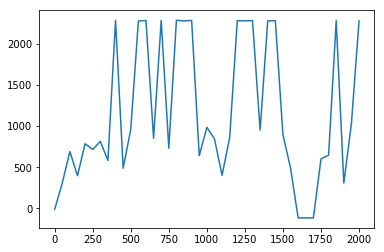

In [22]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [30]:
with open('{}'.format(GAME_NAME.split('/')[1]), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [33]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-06-26 19:44:29,269] Making new env: ppaquette/DoomCorridor-v0
[2017-06-26 19:44:29,274] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 19:44:29,517] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.13112.video000000.mp4


Episode finished after 35 timesteps with reward=2282.4564514160156


[2017-06-26 19:44:30,770] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.13112.video000001.mp4


Episode finished after 31 timesteps with reward=909.9263763427734
Episode finished after 33 timesteps with reward=2277.551239013672
Episode finished after 34 timesteps with reward=2276.6138458251953
Episode finished after 32 timesteps with reward=2276.0274200439453
Episode finished after 35 timesteps with reward=2277.710220336914
Episode finished after 36 timesteps with reward=1151.6846160888672


[2017-06-26 19:44:34,529] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.13112.video000008.mp4


Episode finished after 33 timesteps with reward=2284.085464477539
Episode finished after 34 timesteps with reward=2283.073013305664
Episode finished after 33 timesteps with reward=2281.4502563476562
Episode finished after 34 timesteps with reward=2276.3455657958984
Episode finished after 31 timesteps with reward=1058.6244354248047
Episode finished after 35 timesteps with reward=2279.2674865722656
Episode finished after 25 timesteps with reward=772.1790161132812
Episode finished after 32 timesteps with reward=2279.2066650390625
Episode finished after 33 timesteps with reward=2281.9510040283203
Episode finished after 35 timesteps with reward=2278.485321044922
Episode finished after 34 timesteps with reward=2277.7757568359375
Episode finished after 33 timesteps with reward=2280.217544555664
Episode finished after 33 timesteps with reward=2278.070770263672
Episode finished after 33 timesteps with reward=2277.598648071289
Episode finished after 31 timesteps with reward=1030.8712310791016
Ep

[2017-06-26 19:44:43,479] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.13112.video000027.mp4


Episode finished after 34 timesteps with reward=2283.6687774658203
Episode finished after 34 timesteps with reward=2279.7552795410156
Episode finished after 34 timesteps with reward=2281.897247314453
Episode finished after 35 timesteps with reward=2282.595718383789
Episode finished after 33 timesteps with reward=2280.4553985595703
Episode finished after 35 timesteps with reward=2281.7308502197266
Episode finished after 33 timesteps with reward=2284.131362915039
Episode finished after 33 timesteps with reward=2279.1885833740234
Episode finished after 33 timesteps with reward=2279.6123809814453
Episode finished after 33 timesteps with reward=2282.833023071289
Episode finished after 34 timesteps with reward=2279.2671661376953
Episode finished after 35 timesteps with reward=2276.334732055664
Episode finished after 34 timesteps with reward=2283.420455932617
Episode finished after 33 timesteps with reward=2281.2052154541016
Episode finished after 33 timesteps with reward=2286.6217041015625
E

[2017-06-26 19:45:00,728] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.13112.video000064.mp4


Episode finished after 34 timesteps with reward=2276.0742797851562
Episode finished after 34 timesteps with reward=2286.2654724121094
Episode finished after 34 timesteps with reward=1109.173583984375
Episode finished after 35 timesteps with reward=2284.344696044922
Episode finished after 33 timesteps with reward=2282.1509857177734
Episode finished after 35 timesteps with reward=2282.1963958740234
Episode finished after 34 timesteps with reward=2279.7651977539062
Episode finished after 33 timesteps with reward=2278.4097900390625
Episode finished after 34 timesteps with reward=2278.1659240722656
Episode finished after 33 timesteps with reward=2281.3643798828125
Episode finished after 29 timesteps with reward=936.3739013671875
Episode finished after 34 timesteps with reward=2281.535125732422
Episode finished after 34 timesteps with reward=2278.0887603759766
Episode finished after 30 timesteps with reward=855.2268524169922
Episode finished after 36 timesteps with reward=2276.648681640625
E

[2017-06-26 19:45:17,363] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 33 timesteps with reward=2280.7317504882812
mean session score=2076.248888.5


In [35]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
gym.upload('/home/ubuntu/records')

[2017-06-26 19:46:19,649] [DoomCorridor-v0] Uploading 100 episodes of training data
[2017-06-26 19:46:20,304] [DoomCorridor-v0] Uploading videos of 5 training episodes (1776987 bytes)
[2017-06-26 19:46:20,469] [DoomCorridor-v0] Creating evaluation object from /home/ubuntu/records with learning curve and training video
[2017-06-26 19:46:21,385] 
****************************************************
You successfully uploaded your evaluation on DoomCorridor-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_EqJ7nfC6R6KqO5R7XsFBIA

****************************************************


In [37]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}.pcl".format(GAME_NAME.split('/')[1]))

In [38]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets